In [1]:
#Dan's Notes: 
#we tried ffill for cabin, next we try bfill, then filling each of the side-deck-num individually 
#we didn't check or handle any outliers yet !
#Try MissForest Imputation for mixed variables (continuous-categorical)


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)


In [4]:
data=pd.read_csv('train.csv')
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
#data['CryoSleep'].value_counts()
data['HomePlanet'].value_counts()
#data['Destination'].value_counts()

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

In [6]:
#sns.displot(data1, x='VRDeck',y='Transported',binwidth=3,kind='kde')

In [7]:
#sns.displot(data1, x="Spending", hue="Transported", kind="kde",bw_adjust=100)

In [8]:
class PreProcessing():
    def __init__(self, df : pd.DataFrame = pd.DataFrame) :
        self.df = df
        
    
    def Information (self , df) :
        self.df = df
        df.replace('?' , np.nan , inplace = True )
        nulls = (df.shape[0] - df.dropna(axis = 0).shape[0])
        nulls_per = (df.shape[0] - df.dropna(axis = 0).shape[0]) / df.shape[0]
        dup , dup_per = df.duplicated().sum() , (df.duplicated().sum()) / df.shape[0]
        numerical_columns = list((df.select_dtypes(include=np.number)).columns)
        categorical_columns = list(df.select_dtypes(include = ['object']).columns)
        numerical_col_dict = {}
        for col in numerical_columns :
            if df[col].nunique() > 10 :
                numerical_col_dict[col] = 'Continuous' 

            else :
                numerical_col_dict[col] = 'Discrete'
        categorical_col_dict = {}
        for col in categorical_columns :
            if df[col].nunique() > 10 :
                categorical_col_dict[col] = 'Continuous' 

            else :
                categorical_col_dict[col] = 'Classes'
        x = []
        for col in df.columns : 
            x.append([col , df[col].unique() ,df[col].nunique(),df[col].dtype,df[col].isna().sum(),int((df[col].isna().sum())/df.shape[0] * 100)  ])

        x = pd.DataFrame(x ,columns=['Feature','Unique_Values','No.OfUniqueValues','DataType','NoOfNulls','Nulls %'])
        
        print('\n','There is : {}  Nulls, Representing {} % of The Data'.format(nulls , '%.2f'%nulls_per ))
        print('\n','There is : {}  Duplicated, Representing {} % of The Data'.format(dup , '%.2f'%dup_per))
        print('\n','Numerical Columns : {}'.format(numerical_col_dict))
        print('\n','Categorical Columns : {}'.format(categorical_col_dict))
        
        return x
    
    def ImputeNulls(self , df , col_method : dict = {} ,col_value = {} ,type_method : dict = {} ) :
        self.df = df
        self.col_method = col_method
        self.type_method = type_method
        self.col_value = col_value
        df_copy = df.copy(deep = True)
        if len(col_method) == 0 & len(type_method) == 0  : 
            numerical_columns = list((df_copy.select_dtypes(include=np.number)).columns)
            categorical_columns = list(df_copy.select_dtypes(include = ['object']).columns)

            for col in numerical_columns :
                df_copy[col] = df_copy[col].interpolate()
                
            df_copy[categorical_columns] = df_copy[categorical_columns].apply(lambda x:x.fillna(x.value_counts().index[0]))
    
                
        if len(col_method) != 0 :
            for col in col_method.keys() :
                df_copy[col] = df_copy[col].fillna(method = col_method[col])
        
        if len(col_value) != 0 :
            for col in col_value.keys() :
                df_copy[col] = df_copy[col].fillna(value = col_value[col])
        
        if len(type_method) != 0 :
            numerical_columns = list((df_copy.select_dtypes(include=np.number)).columns)
            categorical_columns = list(df_copy.select_dtypes(include = ['object']).columns)
            for col in numerical_columns :
                df_copy[col] = df_copy[col].fillna(method = type_method['int'])
                
            for col in categorical_columns :
                df_copy[col] = df_copy[col].fillna(method = type_method['object'])
                
        return df_copy
    
    
    def Oultiers(self , df , display = False , drop = False , drop_order = 1 ,columns_to_display = [], columns_to_drop = []) :
        self.df = df
        self.display = display
        self.drop = drop
        self.drop_order = drop_order
        self.columns_to_display = columns_to_display
        self.columns_to_drop = columns_to_drop
        df_copy = df.copy(deep = True)
        numerical_columns = list((df_copy.select_dtypes(include=np.number)).columns)


        if display == True :
            if (len(columns_to_display) != 0) :
                numerical_columns = columns_to_display
            from math import ceil
            x = ceil(len(numerical_columns)/2)
            if len(numerical_columns) >= 24 :
                fig = plt.figure(figsize=(128,96))
            else : 
                fig = plt.figure(figsize=(24, 12))

            sns.set_theme(style="whitegrid", palette="pastel")
            plt.subplots_adjust(hspace=0.5)
            subfigs = fig.subfigures(len(numerical_columns), 1)
            for idx , i in enumerate(numerical_columns) :
                (ax1, ax2) = subfigs[idx].subplots(1, 2)
                sns.boxplot(x = df_copy[i] ,data = df_copy , ax = ax1 )
                sns.histplot(x = df_copy[i], kde=True , ax = ax2 )
                subfigs[idx].subplots_adjust(bottom=0.5, right=0.8, top=0.75)
                ax1.set_title(i)
                ax2.set_title(i)

        if drop == True :
            if (len(columns_to_drop) != 0) :
                numerical_columns = columns_to_drop
            elif drop_order < 1 :
                drop_order = 1

            import scipy.stats as stats

            while drop_order != 0 :
                for col in  numerical_columns :
                    p_value = stats.normaltest(df_copy[col])
                    if p_value[1] >= .05 :                                      ## col is normally distributed
                        filt = (df_copy[col]-df_copy[col].mean())/df_copy[col].std()
                        indexes = (filt[filt > 3]).index
                        df_copy.drop(indexes , inplace = True )
                        df_copy.reset_index(drop=True , inplace=True)

                    else :                                                     ## col is Skewed 

                        q1 = df_copy[col].quantile(0.25)
                        q3 = df_copy[col].quantile(0.75)
                        iqr = q3 - q1
                        lower = q1 - 1.5*iqr
                        if lower < 0 :
                            lower = 0
                        higher = q3 + 1.5*iqr
                        df_copy = df_copy [df_copy[col] >= lower] 
                        df_copy = df_copy [df_copy[col] <= higher ]
                        df_copy.reset_index(drop=True , inplace=True)

                drop_order = drop_order - 1
                
        return df_copy

       
        
    def Encode_Categorical(self , df , col_method={} ,one_hot = False , labeling = False ,defult = False ) :
        self.df = df 
        self.one_hot = one_hot
        self.labeling = labeling
        self.col_method = col_method
        df_copy = df.copy(deep = True)
        from sklearn import preprocessing
        
        if len(col_method) != 0 :
            label_cols = []
            one_hot_cols = []
            
            for col in col_method.keys() :
                if 'label' in col_method[col] :
                    label_cols.append(col)
                else :
                    one_hot_cols.append(col)
            if len(label_cols) !=0 :
                label_encoder = preprocessing.LabelEncoder()
                for col in label_cols :
                    df_copy[col]= label_encoder.fit_transform(df_copy[col])
            if len(one_hot_cols) !=0 :
                dummies = pd.get_dummies(one_hot_cols , drop_first=True)
                df_copy.drop(one_hot_cols,axis=1,inplace=True)
                df_copy = df_copy.join(dummies)

        
        elif defult == True :
            categorical_columns = list(df_copy.select_dtypes(include = ['object']).columns)
            one_hot_encoding = []
            label_encoder = preprocessing.LabelEncoder()
            for col in categorical_columns :
                if df_copy[col].nunique() < 20 :
                    one_hot_encoding.append(col)
                    
                else :
                    df_copy[col]= label_encoder.fit_transform(df_copy[col])
                    
            df_copy = pd.get_dummies(df_copy , drop_first=True)
                    
                
                    
        
        elif one_hot == True :
            df_copy = pd.get_dummies(df_copy , drop_first=True)
            
        elif labeling == True :
            from sklearn import preprocessing
            label_encoder = preprocessing.LabelEncoder()
            for col in df_copy.columns :
                df_copy[col]= label_encoder.fit_transform(df_copy[col])
                
                
        return df_copy
    
    
    def Model (self , df , model ,target_name , problem ,test_size = 0.3 , random_state = 42 ) :
        self.df = df
        self.model = model
        self.target_name = target_name
        self.problem = problem
        self.test_size = test_size
        self.random_state = random_state
        
        
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import accuracy_score ,recall_score,precision_score,f1_score ,classification_report , r2_score
        x = df.drop([target_name] , axis = 1)
        y = df[target_name]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = random_state)
        
        list_of_models = [model]
        if problem == 'Classification' :
            classification_report = pd.DataFrame(columns=['Accuracy','F1_score','Precision','Recall'])
            for model in list_of_models :
                model = model
                model.fit(x_train , y_train)
                for i in range(2) :

                    if i == 0 :
                        to_pred = x_train
                        pred = y_train
                        title = 'Train'

                    else :
                        to_pred = x_test
                        pred = y_test
                        title = 'Test'
                    y_pred = model.predict(to_pred)
                    acc = round(accuracy_score(pred , y_pred)*100)
                    f1 = round(f1_score(pred , y_pred)*100)
                    prec = round(precision_score(pred , y_pred)*100)
                    recall = round(recall_score(pred , y_pred)*100)
                    d = pd.DataFrame(data=np.array([acc,f1,prec,recall]).reshape(1,4) 
                                 , columns=['Accuracy' , 'F1_score' , 'Precision' , 'Recall'])  
                    classification_report = pd.concat([classification_report , d])
                    classification_report.rename( index= { 0 :'{} _ {} Details'.format(model , title) } ,inplace=True )
                    
        elif problem == 'Regression' :
            classification_report = pd.DataFrame(columns=['Score'])
            for model in list_of_models :
                model = model
                model.fit(x_train , y_train)
                for i in range(2) :

                    if i == 0 :
                        to_pred = x_train
                        pred = y_train
                        title = 'Train'

                    else :
                        to_pred = x_test
                        pred = y_test
                        title = 'Test'
                    y_pred = model.predict(to_pred)
                    acc = round(r2_score(pred , y_pred)*100)
                    d = pd.DataFrame(data=np.array([acc]).reshape(1,1) 
                                 , columns=['Score'])  
                    classification_report = pd.concat([classification_report , d])
                    classification_report.rename( index= { 0 :'{} _ {} Details'.format(model , title) } ,inplace=True )
                    
        print(classification_report)
        return model


In [9]:
pre=PreProcessing()

In [10]:
data['PassengerId'].value_counts()

PassengerId
0001_01    1
6136_01    1
6141_01    1
6139_06    1
6139_05    1
          ..
3126_01    1
3124_03    1
3124_02    1
3124_01    1
9280_02    1
Name: count, Length: 8693, dtype: int64

In [11]:
data[['PassengerGrp','Id']]=data['PassengerId'].str.split('_',expand=True)
print(data.PassengerGrp.nunique())
data = data.astype({'PassengerGrp':'int'})

6217


In [12]:
j=0
for i in range(len(data.PassengerGrp)):

    for j in range(str(data.PassengerId[i])):
        
    if i==J:
        pass
    else: 
        

IndentationError: expected an indented block after 'for' statement on line 4 (3353919030.py, line 6)

In [13]:
#data['Cabin']=data['Cabin'].str()
data = data.astype({'Cabin':'string'})
data['Cabin']

0          B/0/P
1          F/0/S
2          A/0/S
3          A/0/S
4          F/1/S
          ...   
8688      A/98/P
8689    G/1499/S
8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: Cabin, Length: 8693, dtype: string

In [14]:
#data['Cabin_side'].isna().value_counts()
#data['Cabin_num'].isna()
#tempNA=pd.DataFrame()
#tempNA['num'] = data[['Cabin_num']].isna().any(axis=1)
#tempNA['side'] = data[['Cabin_side']].isna().any(axis=1)
#tempNA['deck'] = data[['Cabin_deck']].isna().any(axis=1)
#data['Cabin_deck'].isna().value_counts()

In [15]:
#mask=data[['Cabin_side']].isna().any(axis=1)
#data.Cabin.dropna(axis=0,inplace=True)
data.Cabin.ffill(inplace=True)

In [16]:
data.Cabin.isna().value_counts()

Cabin
False    8693
Name: count, dtype: int64

In [17]:
data[['Cabin_deck','Cabin_num','Cabin_side']]=data['Cabin'].str.split('/',expand=True)


In [18]:
data.Cabin_num=data.Cabin_num.astype(int)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8693 non-null   string 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  PassengerGrp  8693 non-null   int32  
 15  Id            8693 non-null   object 
 16  Cabin_deck    8693 non-null   string 
 17  Cabin_num     8693 non-null   int32  
 18  Cabin_side    8693 non-null 

In [20]:
data.Cabin_deck.unique()

<StringArray>
['B', 'F', 'A', 'G', 'E', 'D', 'C', 'T']
Length: 8, dtype: string

In [21]:
data.Cabin_num.nunique()

1817

In [22]:
data.Cabin_side.unique()

<StringArray>
['P', 'S']
Length: 2, dtype: string

In [23]:
pg=data.groupby('Cabin_num')['Transported'].count().sort_values()
pg.head(2)

Cabin_num
1894    1
1617    1
Name: Transported, dtype: int64

In [24]:
data.Cabin_deck.value_counts()

Cabin_deck
F    2847
G    2626
E     897
B     803
C     764
D     485
A     266
T       5
Name: count, dtype: Int64

<Axes: xlabel='Cabin_deck', ylabel='count'>

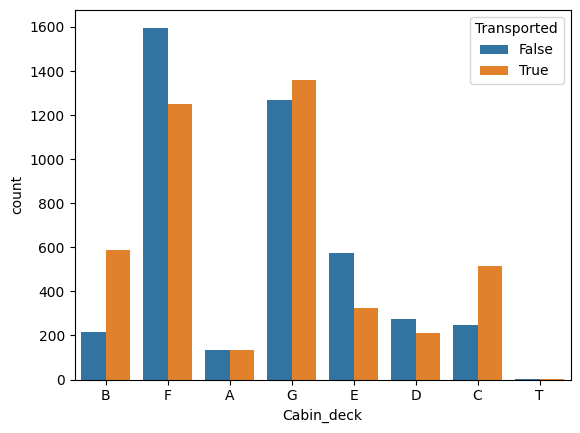

In [25]:
sns.countplot(data,x=data['Cabin_deck'],hue='Transported')


In [26]:
#label encoding for cabin_deck {'A':1, 'B':5, 'C':4, 'D':2,'E':3, 'F':6, 'G':7, 'T':1}

In [27]:
Cabin_deck_labels={'A':'1', 'B':'5', 'C':'4', 'D':'2','E':'3', 'F':'6', 'G':'7','T':'1'}

# Nominal Encoding for Cabin Deck 

In [28]:
data['Cabin_deck'].replace(Cabin_deck_labels,inplace=True)
data.Cabin_deck=data.Cabin_deck.astype(int)

In [29]:
data['Cabin_deck']

0       5
1       6
2       1
3       1
4       6
       ..
8688    1
8689    7
8690    7
8691    3
8692    3
Name: Cabin_deck, Length: 8693, dtype: int32

In [30]:
#data.drop(['Cabin_deck'=='T'],inplace=True)
#data=data.drop(data[data['Cabin_deck']=='T'])

# Preprocessing

In [31]:
pre.Information(data)


 There is : 1929  Nulls, Representing 0.22 % of The Data

 There is : 0  Duplicated, Representing 0.00 % of The Data

 Numerical Columns : {'Age': 'Continuous', 'RoomService': 'Continuous', 'FoodCourt': 'Continuous', 'ShoppingMall': 'Continuous', 'Spa': 'Continuous', 'VRDeck': 'Continuous', 'PassengerGrp': 'Continuous', 'Cabin_deck': 'Discrete', 'Cabin_num': 'Continuous'}

 Categorical Columns : {'PassengerId': 'Continuous', 'HomePlanet': 'Classes', 'CryoSleep': 'Classes', 'Destination': 'Classes', 'VIP': 'Classes', 'Name': 'Continuous', 'Id': 'Classes'}


,Feature,Unique_Values,No.OfUniqueValues,DataType,NoOfNulls,Nulls %
0,PassengerId,"[0001_01, 0002_01, 0003_01, 0003_02, 0004_01, ...",8693,object,0,0
1,HomePlanet,"[Europa, Earth, Mars, nan]",3,object,201,2
2,CryoSleep,"[False, True, nan]",2,object,217,2
3,Cabin,"[B/0/P, F/0/S, A/0/S, F/1/S, F/0/P, F/2/S, G/0...",6560,string[python],0,0
4,Destination,"[TRAPPIST-1e, PSO J318.5-22, 55 Cancri e, nan]",3,object,182,2
5,Age,"[39.0, 24.0, 58.0, 33.0, 16.0, 44.0, 26.0, 28....",80,float64,179,2
6,VIP,"[False, True, nan]",2,object,203,2
7,RoomService,"[0.0, 109.0, 43.0, 303.0, 42.0, 39.0, 73.0, 71...",1273,float64,181,2
8,FoodCourt,"[0.0, 9.0, 3576.0, 1283.0, 70.0, 483.0, 1539.0...",1507,float64,183,2
9,ShoppingMall,"[0.0, 25.0, 371.0, 151.0, 3.0, 17.0, nan, 589....",1115,float64,208,2


In [32]:
#data1=data.copy(deep=True)
#data1['Spending']=data['FoodCourt']+data['RoomService']+data['ShoppingMall']+data['Spa']+data['VRDeck']
#data1['Spending'].isna().value_counts()
#asdasd

In [33]:
#sns.countplot(data=data2, x=data2.)

In [34]:
#Destination Cats:   ;TRAPPIST-1e, PSO J318.5-22, 55 Cancri e
#HomePlanet  Cats: Europa, Earth, Mars,

cat=pd.DataFrame(data[['PassengerId', 'HomePlanet', 'Cabin','CryoSleep', 'Destination', 'VIP', 'Name','Cabin_side']])
#cat.head()
cat = cat.apply(lambda x:x.fillna(x.value_counts().index[0]))
#cat.HomePlanet.fillna(value='Mars',inplace=True)
#cat.Destination.fillna(value='PSO J318.5-22',inplace=True)
#cat.VIP.fillna(value='False',inplace=True)
cat.head()

,PassengerId,HomePlanet,Cabin,CryoSleep,Destination,VIP,Name,Cabin_side
0,0001_01,Europa,B/0/P,False,TRAPPIST-1e,False,Maham Ofracculy,P
1,0002_01,Earth,F/0/S,False,TRAPPIST-1e,False,Juanna Vines,S
2,0003_01,Europa,A/0/S,False,TRAPPIST-1e,True,Altark Susent,S
3,0003_02,Europa,A/0/S,False,TRAPPIST-1e,False,Solam Susent,S
4,0004_01,Earth,F/1/S,False,TRAPPIST-1e,False,Willy Santantines,S


In [35]:
#data.CryoSleep.fillna(value=data.CryoSleep.value_counts().index[-1])
#data.CryoSleep.head()

In [36]:
#num=pd.DataFrame(data[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Cabin_num']])
#num.head()

In [37]:
num=pd.DataFrame(data[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Cabin_num','Cabin_deck']])
#num=pd.DataFrame()
#num['total_spending']=pd.DataFrame((data['RoomService']+ data['FoodCourt']+data['ShoppingMall']+data['Spa']+data['VRDeck']))
#num[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].interpolate(inplace=True)
#num.interpolate(inplace=True)
num = num.apply(lambda x:x.fillna(x.median()))
#num.isna().value_counts()
num.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_num,Cabin_deck
0,39.0,0.0,0.0,0.0,0.0,0.0,0,5
1,24.0,109.0,9.0,25.0,549.0,44.0,0,6
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0,1
4,16.0,303.0,70.0,151.0,565.0,2.0,1,6


In [38]:
data2=pd.concat([cat,num,data['Transported']], axis=1, join='outer')
data2.head()

,PassengerId,HomePlanet,Cabin,CryoSleep,Destination,VIP,Name,Cabin_side,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_num,Cabin_deck,Transported
0,0001_01,Europa,B/0/P,False,TRAPPIST-1e,False,Maham Ofracculy,P,39.0,0.0,0.0,0.0,0.0,0.0,0,5,False
1,0002_01,Earth,F/0/S,False,TRAPPIST-1e,False,Juanna Vines,S,24.0,109.0,9.0,25.0,549.0,44.0,0,6,True
2,0003_01,Europa,A/0/S,False,TRAPPIST-1e,True,Altark Susent,S,58.0,43.0,3576.0,0.0,6715.0,49.0,0,1,False
3,0003_02,Europa,A/0/S,False,TRAPPIST-1e,False,Solam Susent,S,33.0,0.0,1283.0,371.0,3329.0,193.0,0,1,False
4,0004_01,Earth,F/1/S,False,TRAPPIST-1e,False,Willy Santantines,S,16.0,303.0,70.0,151.0,565.0,2.0,1,6,True


In [39]:
#Age_avg=pd.Series(data['Age'].value_counts().head(5))
#AgeAvg=pd.Series(Age_avg.index).sum()/len(Age_avg.index)
#AgeAvg
#data['Age'].fillna(value=AgeAvg, inplace=True)
#data2['Age'].fillna(value=data2['Age'].median())
#data2['Age'].isna().value_counts()

#data2['Cabin'].isna().value_counts()

In [40]:
data.CryoSleep.isna().value_counts()

CryoSleep
False    8476
True      217
Name: count, dtype: int64

# EDA

In [41]:
data.head(1)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGrp,Id,Cabin_deck,Cabin_num,Cabin_side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,01,5,0,P


In [42]:
data['TotalSpending']=data.RoomService+data.FoodCourt+data.ShoppingMall+data.Spa+data.VRDeck
data.TotalSpending

0           0.0
1         736.0
2       10383.0
3        5176.0
4        1091.0
         ...   
8688     8536.0
8689        0.0
8690     1873.0
8691     4637.0
8692     4826.0
Name: TotalSpending, Length: 8693, dtype: float64

<Axes: xlabel='TotalSpending'>

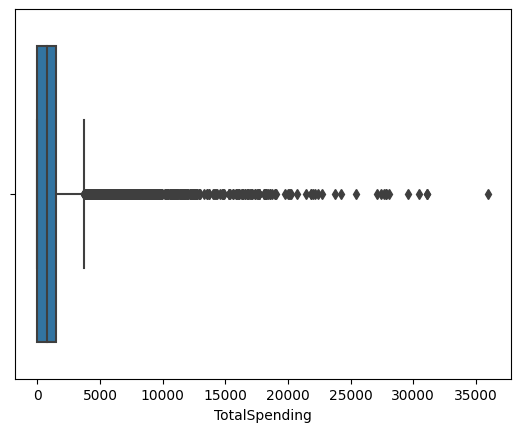

In [43]:
sns.boxplot(data,x='TotalSpending',hue='Transported')

In [44]:
data.TotalSpending.describe()

count     7785.000000
mean      1484.601541
std       2845.288241
min          0.000000
25%          0.000000
50%        736.000000
75%       1486.000000
max      35987.000000
Name: TotalSpending, dtype: float64

<Axes: xlabel='CryoSleep', ylabel='count'>

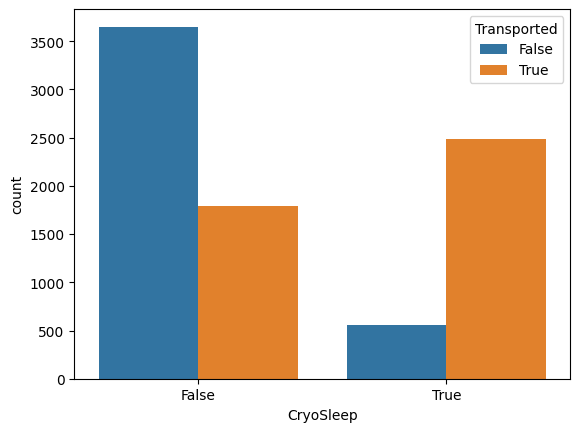

In [45]:
sns.countplot(data,x=data['CryoSleep'],hue='Transported')


<Axes: xlabel='HomePlanet', ylabel='count'>

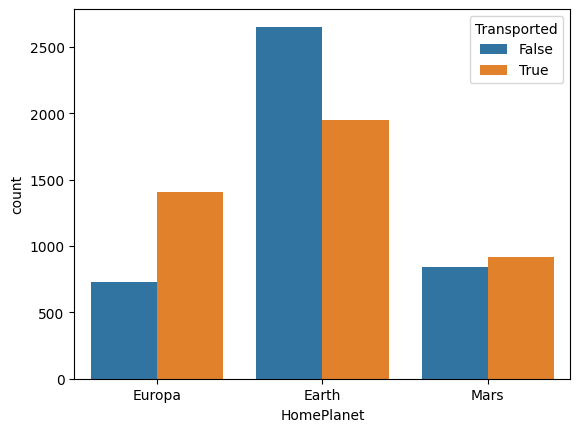

In [46]:
sns.countplot(data, x='HomePlanet', hue='Transported')

In [47]:
data2.HomePlanet.value_counts()

HomePlanet
Earth     4803
Europa    2131
Mars      1759
Name: count, dtype: int64

<Axes: xlabel='Destination', ylabel='count'>

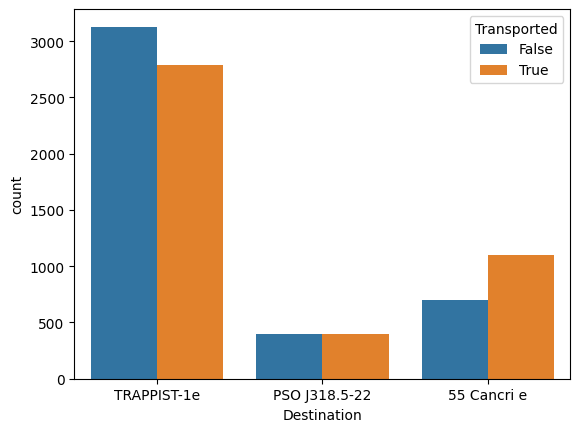

In [48]:
sns.countplot(data, x='Destination', hue='Transported')

In [ ]:
sns.countplot(data, x='Cabin_deck', hue='Transported')

<Axes: xlabel='Cabin_side', ylabel='count'>

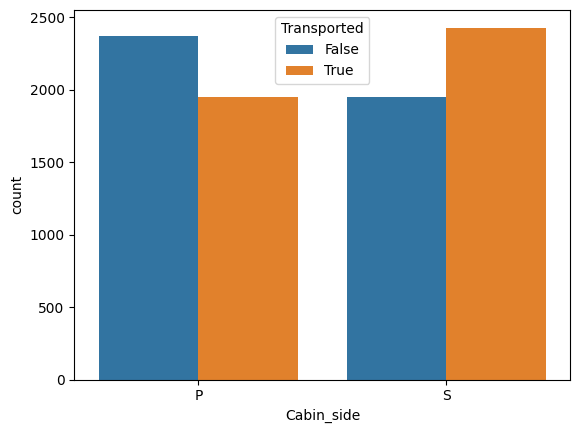

In [43]:
sns.countplot(data, x='Cabin_side', hue='Transported')

<Axes: xlabel='CryoSleep', ylabel='count'>

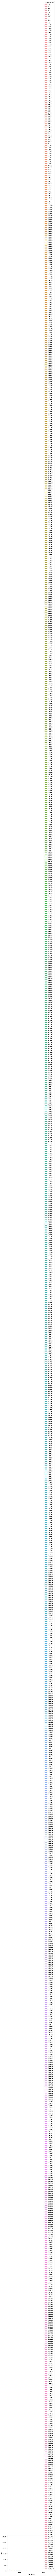

In [44]:
sns.countplot(data, x='CryoSleep', hue='RoomService')

In [ ]:
sns.countplot(data, x='VIP', hue='Transported')

In [ ]:
data2.info()

# Encoding 

In [32]:
one_hot_encoded_data = pd.get_dummies(data2, columns = ['HomePlanet', 'CryoSleep','VIP','Destination','Cabin_side'],drop_first=True)
one_hot_encoded_data.head()

,PassengerId,Cabin,Name,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_num,Cabin_deck,Transported,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,VIP_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_side_S
0,0001_01,B/0/P,Maham Ofracculy,39.0,0.0,0.0,0.0,0.0,0.0,0,5,False,True,False,False,False,False,True,False
1,0002_01,F/0/S,Juanna Vines,24.0,109.0,9.0,25.0,549.0,44.0,0,6,True,False,False,False,False,False,True,True
2,0003_01,A/0/S,Altark Susent,58.0,43.0,3576.0,0.0,6715.0,49.0,0,1,False,True,False,False,True,False,True,True
3,0003_02,A/0/S,Solam Susent,33.0,0.0,1283.0,371.0,3329.0,193.0,0,1,False,True,False,False,False,False,True,True
4,0004_01,F/1/S,Willy Santantines,16.0,303.0,70.0,151.0,565.0,2.0,1,6,True,False,False,False,False,False,True,True


In [ ]:
data2.head()

In [33]:
data2=pd.concat([cat,one_hot_encoded_data], axis=1, join='outer')
#data2['Transported']=data['Transported']
data2.drop(data2[['HomePlanet','VIP','Destination', 'CryoSleep','PassengerId','Name','Cabin','Cabin_side']],axis=1, inplace=True)
data2.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_num,Cabin_deck,Transported,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,VIP_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_side_S
0,39.0,0.0,0.0,0.0,0.0,0.0,0,5,False,True,False,False,False,False,True,False
1,24.0,109.0,9.0,25.0,549.0,44.0,0,6,True,False,False,False,False,False,True,True
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0,1,False,True,False,False,True,False,True,True
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0,1,False,True,False,False,False,False,True,True
4,16.0,303.0,70.0,151.0,565.0,2.0,1,6,True,False,False,False,False,False,True,True


In [34]:
X=data2.drop('Transported',axis=1)
y=pd.array(data2['Transported'])
X.shape

(8693, 15)

In [35]:
y.shape

(8693,)

In [ ]:
#features = [x for x in df.columns if x not in 'HeartDisease'] ## Removing our target variable

In [ ]:
data2.head(50)

# Baseline Model

In [36]:
from sklearn.model_selection import cross_val_predict,cross_val_score,cross_validate,  train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score


RS=42  #standerizing random_state to 42 

In [37]:
lr=LogisticRegression()
dt=DecisionTreeClassifier()
rf=RandomForestClassifier()

# Feature Scaling

In [ ]:
#std= StandardScaler()


In [ ]:
#X=std.fit_transform(X)

# Train-Test-Validation Split

In [38]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 , random_state = 42)

In [ ]:
#x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, test_size= 0.25, random_state= 42)

In [39]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(6085, 15) (6085,) (2608, 15) (2608,)


In [ ]:
#print(x_train.shape,x_test.shape, x_val.shape)

In [ ]:
#lr=LogisticRegression(max_iter=100,solver='liblinear')
#lr.fit(x_train,y_train)

In [ ]:
#print('Training Score:',lr.score(x_train,y_train),'Testing Score', lr.score(x_test, y_test),'F1 Score:',f1_score(ypredLR,y_test) )

In [ ]:
#ypredLR=lr.predict(x_test)
#f1_score(ypredLR,y_test)

# Decision Tree 

In [ ]:
#dt=DecisionTreeClassifier()
#dt.fit(x_train,y_train)

In [ ]:
#dt.score(x_test,y_test)

In [ ]:
#y_pred=dt.predict(x_test)

In [ ]:
#f1_score(y_pred,y_test)

In [ ]:
#notes to improve the model: try adding all spendables to one column, try different encoding, try different NAN filling method
#try to extract more data from cabin, do manual logistic regression with sigmoid, improve manual model accuracy to come close
#to decision tree accuracy

# Random Forest

In [ ]:
#rf=RandomForestClassifier()

In [ ]:
#rf.fit(x_train,y_train)

In [ ]:
#rf.score(x_test,y_test)

In [ ]:
#ypredRF=rf.predict(x_test)
#f1_score(ypredRF,y_test)

# CrossValidation for all models

In [84]:
lrParams= {
    'penalty': [ 'l2'],
    'C': [0.1, 1, 10, 100],
    'random_state':[RS],
    'solver':['liblinear'],
    'verbose': [2]
}
dtParams= {
         'criterion':['gini','entropy'],  
         'max_depth':range(1,10), 
         'min_samples_split':range(2,5),
         'min_samples_leaf':range(2,5),  
         'max_features':[1,0.25,0.5,0.75], 
         'random_state':[RS],
         'verbose': [2]
         }



rfParams = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110],
    'max_features': range(2,5),
    'min_samples_leaf': range(5,10),
    'min_samples_split': [2,4],
    'n_estimators': [100],
    'random_state':[RS],
    'verbose': [2]
}

In [41]:
lrCV= GridSearchCV(lr, lrParams, cv=10, n_jobs=2,verbose=2,return_train_score=True)
lrCV.fit(x_train,y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=2,
             param_grid={'C': [0.1, 1, 10, 100], 'penalty': ['l2'],
                         'random_state': [42], 'solver': ['liblinear']},
             return_train_score=True, verbose=2)

In [42]:
lrCV.best_score_

0.7980298267219774

In [45]:
lrCVPred=lrCV.predict(x_test)

In [46]:
f1_score(lrCVPred,y_test)

0.7976878612716763

In [43]:
dtCV= GridSearchCV(dt, dtParams, cv=10, n_jobs=4,verbose=2, return_train_score=True)
dtCV.fit(x_train,y_train)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'max_features': [1, 0.25, 0.5, 0.75],
                         'min_samples_leaf': range(2, 5),
                         'min_samples_split': range(2, 5),
                         'random_state': [42]},
             return_train_score=True, verbose=2)

In [44]:
print(dtCV.best_score_,dtCV.best_estimator_)


0.7796255185377237 DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features=0.75,
                       min_samples_leaf=2, random_state=42)


In [ ]:
#dtCV.score(x_val,y_val)

In [85]:
rfCV= GridSearchCV(rf, rfParams, cv=10, n_jobs=-1)
rfCV.fit(x_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [90, 100, 110],
                         'max_features': range(2, 5),
                         'min_samples_leaf': range(5, 10),
                         'min_samples_split': [2, 4], 'n_estimators': [100],
                         'random_state': [42], 'verbose': [2]})

In [86]:
rfCV.best_score_

0.8098627495462795

In [87]:
rfCV.best_estimator_

RandomForestClassifier(max_depth=90, max_features=2, min_samples_leaf=5,
                       random_state=42, verbose=2)

In [ ]:
#rfCV.best_params_

# Submission 

In [88]:
test=pd.read_csv(r'C:\Users\ritam\Documents\playground\Scripts\titanic\test.csv')
pre.Information(test)


 There is : 996  Nulls, Representing 0.23 % of The Data

 There is : 0  Duplicated, Representing 0.00 % of The Data

 Numerical Columns : {'Age': 'Continuous', 'RoomService': 'Continuous', 'FoodCourt': 'Continuous', 'ShoppingMall': 'Continuous', 'Spa': 'Continuous', 'VRDeck': 'Continuous'}

 Categorical Columns : {'PassengerId': 'Continuous', 'HomePlanet': 'Classes', 'CryoSleep': 'Classes', 'Cabin': 'Continuous', 'Destination': 'Classes', 'VIP': 'Classes', 'Name': 'Continuous'}


,Feature,Unique_Values,No.OfUniqueValues,DataType,NoOfNulls,Nulls %
0,PassengerId,"[0013_01, 0018_01, 0019_01, 0021_01, 0023_01, ...",4277,object,0,0
1,HomePlanet,"[Earth, Europa, Mars, nan]",3,object,87,2
2,CryoSleep,"[True, False, nan]",2,object,93,2
3,Cabin,"[G/3/S, F/4/S, C/0/S, C/1/S, F/5/S, F/7/P, B/2...",3265,object,100,2
4,Destination,"[TRAPPIST-1e, 55 Cancri e, PSO J318.5-22, nan]",3,object,92,2
5,Age,"[27.0, 19.0, 31.0, 38.0, 20.0, 21.0, 23.0, 24....",79,float64,91,2
6,VIP,"[False, nan, True]",2,object,93,2
7,RoomService,"[0.0, 10.0, 339.0, 932.0, 2.0, 26.0, nan, 39.0...",842,float64,82,1
8,FoodCourt,"[0.0, 9.0, 6652.0, 1615.0, nan, 639.0, 3.0, 74...",902,float64,106,2
9,ShoppingMall,"[0.0, 635.0, 263.0, 136.0, nan, 253.0, 243.0, ...",715,float64,98,2


In [89]:
#data['Cabin']=data['Cabin'].str()
test = test.astype({'Cabin':'string'})
test['Cabin']

0          G/3/S
1          F/4/S
2          C/0/S
3          C/1/S
4          F/5/S
          ...   
4272    G/1496/S
4273        <NA>
4274     D/296/P
4275     D/297/P
4276    G/1498/S
Name: Cabin, Length: 4277, dtype: string

In [90]:
test.Cabin.ffill(inplace=True)

In [69]:
test.Cabin.isna().value_counts()

Cabin
False    4277
Name: count, dtype: int64

In [91]:
test[['Cabin_deck','Cabin_num','Cabin_side']]=test['Cabin'].str.split('/',expand=True)
test.Cabin_num=test.Cabin_num.astype(int)
test['Cabin_deck'].replace(Cabin_deck_labels,inplace=True)
test.Cabin_deck=test.Cabin_deck.astype(int)

In [92]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4277 non-null   string 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
 13  Cabin_deck    4277 non-null   int32  
 14  Cabin_num     4277 non-null   int32  
 15  Cabin_side    4277 non-null   string 
dtypes: float64(6), int32(2), object(6), string(2)
memory usage: 501.3+ KB


In [93]:
num1=pd.DataFrame(test[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Cabin_num','Cabin_deck']])
#num=pd.DataFrame()
#num['total_spending']=pd.DataFrame((data['RoomService']+ data['FoodCourt']+data['ShoppingMall']+data['Spa']+data['VRDeck']))
#num[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].interpolate(inplace=True)
#num.interpolate(inplace=True)
num1 = num1.apply(lambda x:x.fillna(x.median()))
#num.isna().value_counts()
num1

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_num,Cabin_deck
0,27.0,0.0,0.0,0.0,0.0,0.0,3,7
1,19.0,0.0,9.0,0.0,2823.0,0.0,4,6
2,31.0,0.0,0.0,0.0,0.0,0.0,0,4
3,38.0,0.0,6652.0,0.0,181.0,585.0,1,4
4,20.0,10.0,0.0,635.0,0.0,0.0,5,6
...,...,...,...,...,...,...,...,...
4272,34.0,0.0,0.0,0.0,0.0,0.0,1496,7
4273,42.0,0.0,847.0,17.0,10.0,144.0,1496,7
4274,26.0,0.0,0.0,0.0,0.0,0.0,296,2
4275,26.0,0.0,2680.0,0.0,0.0,523.0,297,2


In [94]:
#Destination Cats:   ;TRAPPIST-1e, PSO J318.5-22, 55 Cancri e
#HomePlanet  Cats: Europa, Earth, Mars,

cat1=pd.DataFrame(test[['PassengerId', 'HomePlanet', 'Cabin','CryoSleep', 'Destination', 'VIP', 'Name','Cabin_side']])
#cat.head()
cat1 = cat1.apply(lambda x:x.fillna(x.value_counts().index[0]))
#cat.HomePlanet.fillna(value='Mars',inplace=True)
#cat.Destination.fillna(value='PSO J318.5-22',inplace=True)
#cat.VIP.fillna(value='False',inplace=True)
cat1

,PassengerId,HomePlanet,Cabin,CryoSleep,Destination,VIP,Name,Cabin_side
0,0013_01,Earth,G/3/S,True,TRAPPIST-1e,False,Nelly Carsoning,S
1,0018_01,Earth,F/4/S,False,TRAPPIST-1e,False,Lerome Peckers,S
2,0019_01,Europa,C/0/S,True,55 Cancri e,False,Sabih Unhearfus,S
3,0021_01,Europa,C/1/S,False,TRAPPIST-1e,False,Meratz Caltilter,S
4,0023_01,Earth,F/5/S,False,TRAPPIST-1e,False,Brence Harperez,S
...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,G/1496/S,True,TRAPPIST-1e,False,Jeron Peter,S
4273,9269_01,Earth,G/1496/S,False,TRAPPIST-1e,False,Matty Scheron,S
4274,9271_01,Mars,D/296/P,True,55 Cancri e,False,Jayrin Pore,P
4275,9273_01,Europa,D/297/P,False,TRAPPIST-1e,False,Kitakan Conale,P


In [95]:
test=pd.concat([cat1,num1], axis=1, join='outer')
test

,PassengerId,HomePlanet,Cabin,CryoSleep,Destination,VIP,Name,Cabin_side,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_num,Cabin_deck
0,0013_01,Earth,G/3/S,True,TRAPPIST-1e,False,Nelly Carsoning,S,27.0,0.0,0.0,0.0,0.0,0.0,3,7
1,0018_01,Earth,F/4/S,False,TRAPPIST-1e,False,Lerome Peckers,S,19.0,0.0,9.0,0.0,2823.0,0.0,4,6
2,0019_01,Europa,C/0/S,True,55 Cancri e,False,Sabih Unhearfus,S,31.0,0.0,0.0,0.0,0.0,0.0,0,4
3,0021_01,Europa,C/1/S,False,TRAPPIST-1e,False,Meratz Caltilter,S,38.0,0.0,6652.0,0.0,181.0,585.0,1,4
4,0023_01,Earth,F/5/S,False,TRAPPIST-1e,False,Brence Harperez,S,20.0,10.0,0.0,635.0,0.0,0.0,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,G/1496/S,True,TRAPPIST-1e,False,Jeron Peter,S,34.0,0.0,0.0,0.0,0.0,0.0,1496,7
4273,9269_01,Earth,G/1496/S,False,TRAPPIST-1e,False,Matty Scheron,S,42.0,0.0,847.0,17.0,10.0,144.0,1496,7
4274,9271_01,Mars,D/296/P,True,55 Cancri e,False,Jayrin Pore,P,26.0,0.0,0.0,0.0,0.0,0.0,296,2
4275,9273_01,Europa,D/297/P,False,TRAPPIST-1e,False,Kitakan Conale,P,26.0,0.0,2680.0,0.0,0.0,523.0,297,2


In [96]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4277 non-null   object 
 2   Cabin         4277 non-null   string 
 3   CryoSleep     4277 non-null   bool   
 4   Destination   4277 non-null   object 
 5   VIP           4277 non-null   bool   
 6   Name          4277 non-null   object 
 7   Cabin_side    4277 non-null   string 
 8   Age           4277 non-null   float64
 9   RoomService   4277 non-null   float64
 10  FoodCourt     4277 non-null   float64
 11  ShoppingMall  4277 non-null   float64
 12  Spa           4277 non-null   float64
 13  VRDeck        4277 non-null   float64
 14  Cabin_num     4277 non-null   int32  
 15  Cabin_deck    4277 non-null   int32  
dtypes: bool(2), float64(6), int32(2), object(4), string(2)
memory usage: 442.9+ KB


# Submission Encoding 

In [97]:

one_hot_encoded_data1 = pd.get_dummies(test, columns = ['HomePlanet', 'CryoSleep','VIP','Destination','Cabin_side'],drop_first=True)
one_hot_encoded_data1.head()

,PassengerId,Cabin,Name,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_num,Cabin_deck,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,VIP_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_side_S
0,0013_01,G/3/S,Nelly Carsoning,27.0,0.0,0.0,0.0,0.0,0.0,3,7,False,False,True,False,False,True,True
1,0018_01,F/4/S,Lerome Peckers,19.0,0.0,9.0,0.0,2823.0,0.0,4,6,False,False,False,False,False,True,True
2,0019_01,C/0/S,Sabih Unhearfus,31.0,0.0,0.0,0.0,0.0,0.0,0,4,True,False,True,False,False,False,True
3,0021_01,C/1/S,Meratz Caltilter,38.0,0.0,6652.0,0.0,181.0,585.0,1,4,True,False,False,False,False,True,True
4,0023_01,F/5/S,Brence Harperez,20.0,10.0,0.0,635.0,0.0,0.0,5,6,False,False,False,False,False,True,True


In [98]:
test=pd.concat([cat1,one_hot_encoded_data1], axis=1, join='outer')
#data2['Transported']=data['Transported']
test.drop(test[['HomePlanet','VIP','Destination', 'CryoSleep','PassengerId','Name','Cabin','Cabin_side']],axis=1, inplace=True)
test

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_num,Cabin_deck,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,VIP_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_side_S
0,27.0,0.0,0.0,0.0,0.0,0.0,3,7,False,False,True,False,False,True,True
1,19.0,0.0,9.0,0.0,2823.0,0.0,4,6,False,False,False,False,False,True,True
2,31.0,0.0,0.0,0.0,0.0,0.0,0,4,True,False,True,False,False,False,True
3,38.0,0.0,6652.0,0.0,181.0,585.0,1,4,True,False,False,False,False,True,True
4,20.0,10.0,0.0,635.0,0.0,0.0,5,6,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,34.0,0.0,0.0,0.0,0.0,0.0,1496,7,False,False,True,False,False,True,True
4273,42.0,0.0,847.0,17.0,10.0,144.0,1496,7,False,False,False,False,False,True,True
4274,26.0,0.0,0.0,0.0,0.0,0.0,296,2,False,True,True,False,False,False,False
4275,26.0,0.0,2680.0,0.0,0.0,523.0,297,2,True,False,False,False,False,True,False


In [100]:
test_pred=pd.DataFrame(rfCV.predict(test))
test_pred.head()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


,0
0,1.0
1,0.0
2,1.0
3,1.0
4,1.0


In [101]:
test_pred=pd.DataFrame()
test_pred['Transported']=pd.DataFrame(rfCV.predict(test))
test_pred

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


,Transported
0,1.0
1,0.0
2,1.0
3,1.0
4,1.0
...,...
4272,1.0
4273,0.0
4274,1.0
4275,1.0


In [102]:
test_pred['Transported']=test_pred['Transported'].astype(bool)
test_pred['Transported']

0        True
1       False
2        True
3        True
4        True
        ...  
4272     True
4273    False
4274     True
4275     True
4276     True
Name: Transported, Length: 4277, dtype: bool

In [103]:
test1=pd.read_csv(r'C:\Users\ritam\Documents\playground\Scripts\titanic\test.csv')
test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [104]:
submission=pd.concat([test_pred,test1.PassengerId], axis=1, join='outer')
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Transported  4277 non-null   bool  
 1   PassengerId  4277 non-null   object
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


In [105]:
submission.to_csv('submission.csv',index=False)

In [ ]:
y_pred.shape

In [ ]:
lr.score(test,test_pred)

In [ ]:
test_predDT=pd.DataFrame()
test_predDT['Transported']=pd.DataFrame(dtCV.predict(test))
test_predDT

In [ ]:
submission=pd.concat([test_predDT,test1.PassengerId], axis=1, join='outer')
submission.info()

In [ ]:
submission.to_csv('submission.csv',index=False)